# **1. Import Necessary Libraries**
# Importing required libraries for data processing, visualization, and machine learning.


In [40]:
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

# **2. Load Dataset**
# Reading the dataset containing trading data.


In [41]:
df = pd.read_csv('/kaggle/input/trading-data/TRADES_CopyTr_90D_ROI.csv')

# **3. Data Cleaning & Preprocessing**
# Handling missing values, data type conversions, and feature engineering.


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Port_IDs       150 non-null    int64 
 1   Trade_History  149 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.5+ KB


In [43]:
df.head()

,Port_IDs,Trade_History
0,3925368433214965504,"[{'time': 1718899656000, 'symbol': 'SOLUSDT', ..."
1,4002413037164645377,"[{'time': 1718980078000, 'symbol': 'NEARUSDT',..."
2,3923766029921022977,"[{'time': 1718677164000, 'symbol': 'ETHUSDT', ..."
3,3994879592543698688,"[{'time': 1718678214000, 'symbol': 'ETHUSDT', ..."
4,3926423286576838657,"[{'time': 1718979615000, 'symbol': 'ETHUSDT', ..."


In [44]:
df.dropna(subset=['Trade_History'],inplace=True)

In [45]:
df.shape

(149, 2)

In [46]:
df.describe()

,Port_IDs
count,1.490000e+02
mean,3.976029e+18
std,6.895419e+16
min,3.672755e+18
25%,3.944089e+18
50%,3.998659e+18
75%,4.029508e+18
max,4.041860e+18


In [47]:
df['Trade_History'] = df['Trade_History'].apply(ast.literal_eval)

In [48]:
df_exploded = df.explode('Trade_History').reset_index(drop=True)

In [49]:
df_normalized = pd.json_normalize(df_exploded['Trade_History'])

In [50]:
df_normalized['Port_IDs'] = df_exploded['Port_IDs'].values

In [51]:
df_normalized.to_csv('cleaned_trade_data.csv', index=False)

In [52]:
df1 = pd.read_csv('/kaggle/working/cleaned_trade_data.csv')

# **4. Feature Calculation**
# Calculating financial metrics such as ROI, Win Rate, Sharpe Ratio, and MDD.


In [53]:
pnl_per_account = df1.groupby('Port_IDs')['realizedProfit'].sum().reset_index()
pnl_per_account.columns = ['Port_IDs', 'Total_PnL']
pnl_per_account.head()

,Port_IDs,Total_PnL
0,3672754654734989568,566.597660
1,3733192481840423936,2923.977200
2,3768170840939476993,243.668899
3,3784403294629753856,2521.814305
4,3786761687746711808,205.021400


In [54]:
investment_per_account = df1.groupby('Port_IDs')['quantity'].sum().reset_index()
investment_per_account.columns = ['Port_IDs', 'Total_Investment']
roi_df = pnl_per_account.merge(investment_per_account, on='Port_IDs')
roi_df['ROI (%)'] = (roi_df['Total_PnL'] / roi_df['Total_Investment']) * 100
print(roi_df.head())

              Port_IDs    Total_PnL  Total_Investment   ROI (%)
0  3672754654734989568   566.597660      1.189369e+05  0.476385
1  3733192481840423936  2923.977200      1.164472e+06  0.251099
2  3768170840939476993   243.668899      2.775560e+03  8.779089
3  3784403294629753856  2521.814305      7.421060e+05  0.339819
4  3786761687746711808   205.021400      6.174001e+04  0.332072


In [55]:
total_positions = df1.groupby('Port_IDs')['realizedProfit'].count().reset_index()
total_positions.columns = ['Port_IDs', 'Total_Positions']

In [56]:
win_positions = df1[df1['realizedProfit'] > 0].groupby('Port_IDs')['realizedProfit'].count().reset_index()
win_positions.columns = ['Port_IDs', 'Win_Positions']

In [57]:
win_rate_df = total_positions.merge(win_positions, on='Port_IDs', how='left')

In [58]:
win_rate_df['Win_Positions'] = win_rate_df['Win_Positions'].fillna(0)

In [59]:
win_rate_df['Win_Positions'] = win_rate_df['Win_Positions'].fillna(0)
win_rate_df['Win_Rate (%)'] = (win_rate_df['Win_Positions'] / win_rate_df['Total_Positions']) * 100
win_rate_df.head()

,Port_IDs,Total_Positions,Win_Positions,Win_Rate (%)
0,3672754654734989568,474,210.0,44.303797
1,3733192481840423936,689,553.0,80.261248
2,3768170840939476993,14,6.0,42.857143
3,3784403294629753856,6050,1829.0,30.231405
4,3786761687746711808,82,37.0,45.121951


In [60]:
df1 = df1.sort_values(by=['Port_IDs', 'time']).copy()
df1['Cumulative_PnL'] = df1.groupby('Port_IDs')['realizedProfit'].cumsum()
df1['Peak_PnL'] = df1.groupby('Port_IDs')['Cumulative_PnL'].cummax()
df1['Drawdown'] = df1['Cumulative_PnL'] - df1['Peak_PnL']
mdd_per_account = df1.groupby('Port_IDs')['Drawdown'].min().reset_index()
mdd_per_account.columns = ['Port_IDs', 'Max_Drawdown']
peak_pnl_per_account = df1.groupby('Port_IDs')['Peak_PnL'].max().reset_index()
mdd_per_account = mdd_per_account.merge(peak_pnl_per_account, on='Port_IDs', how='left')
mdd_per_account['MDD (%)'] = (mdd_per_account['Max_Drawdown'] / mdd_per_account['Peak_PnL']) * 100
mdd_per_account['MDD (%)'] = mdd_per_account['MDD (%)'].fillna(0)
mdd_per_account['MDD (%)'] = mdd_per_account['MDD (%)'].clip(upper=0, lower=-100)
print(mdd_per_account.head())

              Port_IDs  Max_Drawdown     Peak_PnL    MDD (%)
0  3672754654734989568    -80.777037   566.597660 -14.256507
1  3733192481840423936  -2743.120000  2923.977200 -93.814685
2  3768170840939476993      0.000000   243.668899   0.000000
3  3784403294629753856   -271.291981  2521.814305 -10.757810
4  3786761687746711808   -123.460267   275.225000 -44.857940


In [61]:
df1 = df1.copy()
df1.loc[:, 'returns'] = np.sign(df1['realizedProfit']) * np.log(abs(df1['realizedProfit']) + 1)  
sharpe_df = df1.groupby('Port_IDs')['returns'].agg(['mean', 'std']).reset_index()
sharpe_df.columns = ['Port_IDs', 'Mean_Returns', 'Std_Returns']
sharpe_df.loc[:, 'Std_Returns'] = sharpe_df['Std_Returns'].replace(0, 1)
risk_free_rate = 0.02  
sharpe_df.loc[:, 'Sharpe_Ratio'] = (sharpe_df['Mean_Returns'] - risk_free_rate) / sharpe_df['Std_Returns']
sharpe_df.loc[:, 'Sharpe_Ratio'] = sharpe_df['Sharpe_Ratio'].fillna(0)
print(sharpe_df.head())

              Port_IDs  Mean_Returns  Std_Returns  Sharpe_Ratio
0  3672754654734989568      0.248314     1.037261      0.220112
1  3733192481840423936      1.011507     1.290566      0.768273
2  3768170840939476993      1.126831     1.703651      0.649682
3  3784403294629753856      0.160142     0.603701      0.232138
4  3786761687746711808      0.722852     1.427528      0.492356


In [62]:
final_df = roi_df[['Port_IDs', 'Total_PnL', 'Total_Investment', 'ROI (%)']].drop_duplicates()
final_df = final_df.merge(win_rate_df, on='Port_IDs')
final_df = final_df.merge(mdd_per_account[['Port_IDs', 'MDD (%)']], on='Port_IDs')
final_df = final_df.merge(sharpe_df[['Port_IDs', 'Sharpe_Ratio']], on='Port_IDs')
final_df['Win_Rate (%)'] = final_df['Win_Rate (%)'].clip(lower=0)
final_df.head()

,Port_IDs,Total_PnL,Total_Investment,ROI (%),Total_Positions,Win_Positions,Win_Rate (%),MDD (%),Sharpe_Ratio
0,3672754654734989568,566.597660,1.189369e+05,0.476385,474,210.0,44.303797,-14.256507,0.220112
1,3733192481840423936,2923.977200,1.164472e+06,0.251099,689,553.0,80.261248,-93.814685,0.768273
2,3768170840939476993,243.668899,2.775560e+03,8.779089,14,6.0,42.857143,0.000000,0.649682
3,3784403294629753856,2521.814305,7.421060e+05,0.339819,6050,1829.0,30.231405,-10.757810,0.232138
4,3786761687746711808,205.021400,6.174001e+04,0.332072,82,37.0,45.121951,-44.857940,0.492356


In [63]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149 entries, 0 to 148
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Port_IDs          149 non-null    int64  
 1   Total_PnL         149 non-null    float64
 2   Total_Investment  149 non-null    float64
 3   ROI (%)           149 non-null    float64
 4   Total_Positions   149 non-null    int64  
 5   Win_Positions     149 non-null    float64
 6   Win_Rate (%)      149 non-null    float64
 7   MDD (%)           149 non-null    float64
 8   Sharpe_Ratio      149 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 10.6 KB


In [64]:
final_df.to_csv('final_trade_metrics.csv', index=False)

# **5. Data Visualization**
# Creating plot to analyze correlation.


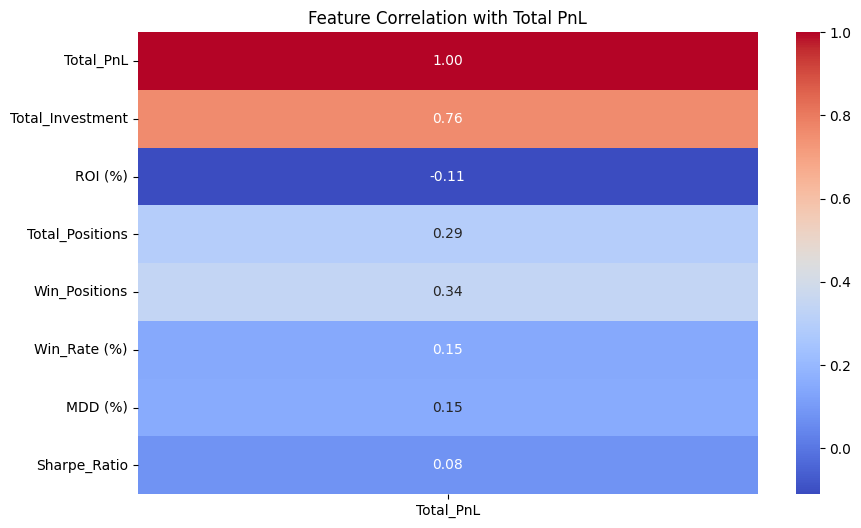

In [65]:
correlation_matrix = final_df.drop(columns=['Port_IDs']).corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix[['Total_PnL']], annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation with Total PnL")
plt.show()

In [66]:
scoring_df = final_df.copy()

In [67]:
scoring_df.head()

,Port_IDs,Total_PnL,Total_Investment,ROI (%),Total_Positions,Win_Positions,Win_Rate (%),MDD (%),Sharpe_Ratio
0,3672754654734989568,566.597660,1.189369e+05,0.476385,474,210.0,44.303797,-14.256507,0.220112
1,3733192481840423936,2923.977200,1.164472e+06,0.251099,689,553.0,80.261248,-93.814685,0.768273
2,3768170840939476993,243.668899,2.775560e+03,8.779089,14,6.0,42.857143,0.000000,0.649682
3,3784403294629753856,2521.814305,7.421060e+05,0.339819,6050,1829.0,30.231405,-10.757810,0.232138
4,3786761687746711808,205.021400,6.174001e+04,0.332072,82,37.0,45.121951,-44.857940,0.492356


# **6. Model Training**
# Using Random Forest Regressor to get weights.


In [68]:
features = ["Total_PnL", "Total_Investment", "ROI (%)", "Total_Positions", "Win_Positions", "Win_Rate (%)", "MDD (%)", "Sharpe_Ratio"]
X = scoring_df[features]
y = scoring_df["Total_PnL"]

In [69]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

RandomForestRegressor(random_state=42)

In [70]:
feature_importance = pd.DataFrame({'Feature': features, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)
print("Feature Importance:\n", feature_importance)

Feature Importance:
             Feature  Importance
0         Total_PnL    0.872819
1  Total_Investment    0.066305
2           ROI (%)    0.018692
7      Sharpe_Ratio    0.013000
6           MDD (%)    0.008396
3   Total_Positions    0.008057
5      Win_Rate (%)    0.006586
4     Win_Positions    0.006145


In [71]:
weights = {
    "Total_PnL": 0.5,   # Slightly lower to balance risk factors
    "Total_Investment": 0.04,
    "ROI (%)": 0.15,      
    "Total_Positions": 0.03,
    "Win_Positions": 0.04,  
    "Win_Rate (%)": 0.04,
    "MDD (%)": -0.35,     # Higher penalty for risky accounts
    "Sharpe_Ratio": 0.4  # More emphasis on risk-adjusted returns
}

# **7. Feature Scaling**
# Normalizing values using Min-Max Scaling to bring them to a common range.


In [72]:
scaler = MinMaxScaler()
scoring_df_scaled = scoring_df.copy()
features = list(weights.keys())
scoring_df_scaled[features] = scaler.fit_transform(scoring_df[features])

# **8. Ranking Accounts**
# Applying a scoring system to rank accounts based on risk-adjusted performance.


In [73]:
scoring_df_scaled["Score"] = sum(scoring_df_scaled[feature] * weight for feature, weight in weights.items())

In [74]:
scoring_df_scaled["Rank"] = scoring_df_scaled["Score"].rank(ascending=False, method='dense')

In [75]:
ranked_accounts = scoring_df_scaled[["Port_IDs", "Total_PnL", "Total_Investment", "ROI (%)", "Total_Positions", "Win_Positions", "Win_Rate (%)", "MDD (%)", "Sharpe_Ratio","Score", "Rank"]].sort_values(by="Rank")
print("\nRanked Accounts:")
ranked_accounts.head(20)


Ranked Accounts:


,Port_IDs,Total_PnL,Total_Investment,ROI (%),Total_Positions,Win_Positions,Win_Rate (%),MDD (%),Sharpe_Ratio,Score,Rank
96,4020204877254599680,1.000000,1.000000,0.040306,0.994235,0.688904,0.410437,0.732173,0.214070,0.449214,1.0
1,3733192481840423936,0.181049,0.050276,0.035416,0.111184,0.191151,1.000000,0.061853,0.786275,0.441691,2.0
75,3999240873283311617,0.651145,0.338787,0.059077,0.742547,0.817836,0.651896,0.992934,0.695145,0.359582,3.0
22,3919174299855478272,0.163649,0.099583,0.020222,0.206391,0.210508,0.598873,0.000000,0.495089,0.325444,4.0
35,3942630767220672256,0.224773,0.052255,0.059294,0.816175,0.657795,0.477160,0.079882,0.393213,0.322581,5.0
85,4008804082027254529,0.185895,0.188298,0.021300,0.158294,0.182164,0.673442,0.110279,0.508223,0.307339,6.0
62,3986814617275053313,0.340079,0.080999,0.085599,0.583100,0.960940,0.974589,0.999854,0.935033,0.305098,7.0
78,4000877324693233921,0.136469,0.407674,0.014392,0.994235,0.938127,0.558919,0.000000,0.306527,0.299020,8.0
17,3907081197088384000,0.359980,0.070811,0.104007,0.679130,0.877981,0.764966,0.885618,0.763825,0.280079,9.0
21,3914654298562589441,0.150454,0.018454,0.021582,0.077253,0.069132,0.515914,0.000000,0.402306,0.265845,10.0


In [76]:
print(final_df.columns)

Index(['Port_IDs', 'Total_PnL', 'Total_Investment', 'ROI (%)',
       'Total_Positions', 'Win_Positions', 'Win_Rate (%)', 'MDD (%)',
       'Sharpe_Ratio'],
      dtype='object')


# **9. Results & Analysis**
# Evaluating the ranking system and interpreting the results.


In [77]:
# 1. Check if any Sharpe Ratios are NaN or infinite
print(sharpe_df['Sharpe_Ratio'].describe()) 

# 2. Ensure MDD (%) is correctly calculated (should not exceed 100%)
print(mdd_per_account[['MDD (%)']].describe())

# 3. Verify ranking logic (higher score → lower rank)
print(ranked_accounts[['Score', 'Rank']].sort_values(by='Score', ascending=False).head(10))

# 4. Ensure no negative ROI or Win Rates (unless expected)
print(scoring_df[(scoring_df['ROI (%)'] < 0) | (scoring_df['Win_Rate (%)'] < 0)])


count    149.000000
mean       0.381473
std        0.225993
min       -0.148032
25%        0.217755
50%        0.363799
75%        0.526099
max        1.017343
Name: Sharpe_Ratio, dtype: float64
            MDD (%)
count  1.490000e+02
mean  -2.038909e+01
std    2.984724e+01
min   -1.000000e+02
25%   -2.512294e+01
50%   -7.879477e+00
75%   -1.961030e-15
max    0.000000e+00
       Score  Rank
96  0.449214   1.0
1   0.441691   2.0
75  0.359582   3.0
22  0.325444   4.0
35  0.322581   5.0
85  0.307339   6.0
62  0.305098   7.0
78  0.299020   8.0
17  0.280079   9.0
21  0.265845  10.0
                Port_IDs     Total_PnL  Total_Investment   ROI (%)  \
9    3858510226868015873   -280.972950      7.873928e+05 -0.035684   
13   3880920727367689984   -176.827000      1.621407e+05 -0.109058   
38   3944239644144231424  -1187.890976      9.564184e+05 -0.124202   
40   3946087913459823360    -40.667242      7.333894e+04 -0.055451   
71   3995532094997544704 -12346.682219      6.608267e+06 -0.186837

# **10. Saving Metrics** 

In [80]:
columns_to_save = ["Port_IDs", "Total_PnL", "Total_Investment", "ROI (%)", "Total_Positions", 
                   "Win_Positions", "Win_Rate (%)", "MDD (%)", "Sharpe_Ratio", "Score", "Rank"]
ranked_accounts[columns_to_save].to_csv("calculated_metrics.csv", index=False)

print("CSV file saved: calculated_metrics.csv")


CSV file saved: calculated_metrics.csv


# **11. Top 20** 

In [82]:
top_20_accounts = ranked_accounts.nsmallest(20, "Rank")

In [87]:
top_20_accounts.to_csv("top_20_accounts.csv", index=False)